# Sending a ramp pulse through a 3 cavity-2 qubit system, <mark>with thermal losses</mark> 

1. **Introduction**
2. **Problem parameters**
3. **Setting up operators, Hamiltonian's, and the initial state**
4. **Generating a pulse wave**
    * No thermal losses considered
5. **Results**
    * Final state, Fidelity, Concurrence

<u>Author</u> : Soumya Shreeram (shreeramsoumya@gmail.com)<br>
<u>Supervisor</u> : Yu-Chin Chao (ychao@fnal.gov) <br>
<u>Date</u>$\ \ \ \$: 22nd July 2019<br>

This script was coded as part of the Helen Edwards Summer Internship program at Fermilab.

## 1. Introduction

A multi-mode QED architecture is explored as described in by [McKay et *al*](http://schusterlab.uchicago.edu/static/pdfs/McKay2015.pdf). The hamiltonian for such a system with two qubits with frequencies $v_{Q,1}$, $v_{Q,2}$, and $n$ mode filter can be described as the sum of the qubit Hamiltonian, $\hat{H}_Q$, the filter Hamiltonian, $\hat{H}_F$, and the qubit-filter coupling Hamiltonian, $\hat{H}_{Q-F},$
$$ \hat{H} = \hat{H_Q} + \hat{H_F} + \hat{H}_{Q-F} $$

$$ \hat{H_Q} = h\ v_{Q,1}\ \frac{\hat{ \sigma}^z_1}{2} + h\ v_{Q,2}\ \frac{\hat{ \sigma}^z_2}{2}$$

$$ \hat{H}_{F} = \sum_{i=1}^{n}h\ v_{F}\ \hat{a}^{\dagger}_i \hat{a}_i +  \sum_{i=2}^{n}h\ g_{F}\ (\hat{a}^{\dagger}_i \hat{a}_{i-1} + \hat{a}^{\dagger}_{i-1} \hat{a}_i)$$

$$ \hat{H}_{Q-F} = h\ g_{Q1,F}\ (\hat{a}^{\dagger}_1 \hat{\sigma}^-_1 + \hat{a}_1 \hat{\sigma}^+_1) + h\ g_{Q2,F}\ (\hat{a}^{\dagger}_n \hat{\sigma}^-_2 + \hat{a}_n \hat{\sigma}^+_2)$$

where $\hat{\sigma}^{+(-)}$ is the raising and lowering operator for the qubit, $\hat{a}_i$ creates a photon in the $i^{th}$ resonantor, $g_F$ is the filter-filter coupling, and $g_{Q,F}$ is the qubit-filter coupling.

Here we must also account for the interaction of the quantum state with it's environment. This can be represented by a non-Hermitian term in the Hamiltonian such that,
$$\displaystyle H_{\rm eff}(t) = H(t) - \frac{i\hbar}{2}\sum_n c_n^\dagger c_n$$
where $c_n$ is the collapse operator

The code calculates the occupation probability for a system when a ramp pulse is genrated at the qubit 1 resonance frequency.

In [405]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import numpy as np
from math import pi
from qutip import *

## 2. Problem parameters
Here we use $\hbar=1$; the coupling terms are redefined with a multiple of $2\pi$ before them for convinience.

In [406]:
"""------------- FREQUENCIES -----------------"""
w_q1 = 2*pi*6.5;     # Qubit 1 frequency
w_q2 = 2*pi*6.8;     # Qubit 2 frequency: range from 1-9 GHz
w_f = 2*pi*7.1;      # Resonator/ Filter frequency

"""------------- COUPLING --------------------"""
g_f1 = 2*pi*0.118    # Filter-filter coupling
g_f2 = 2*pi*0.344 
g_q1f = 2*pi*0.135   # qubit 1-fitler coupling
g_q2f = 2*pi*0.415   # qubit 2-fitler coupling

numF = 3             # number of filters
N = 2                # number of fock states 
times = np.linspace(0,100,500)

"""------------- DISSIPATION PARAMETERS -----"""
kappa = 0.75         # cavity dissipation rate
n_th_a = 0.003       # avg. no. of thermal bath excitation
r1 = 0.075           # qubit relaxation rate
r2 = 0.025           # qubit dephasing rate

"""------------- CONTROL GATE PARAMETERS -----"""
# qubit 1
T0_1 = 10            # start time allowed for ramp up
T1_1 = 15            # stop time for ramp up
slope = 3            # slope at which the pulse is linearly rasied
T_gate_1 = 5         # width of the ramp pusle 
                     
# qubit 2
T0_2 = 160
T1_2 = 162     
T_gate_2 = (2*pi)/(4 * g_q2f)
T_gate_2 = 100

## 3. Setting up the operators, Hamiltonian's, and Initial state

For every qubit: <br> <br>
**sm** $\ \rightarrow \ \hat{\sigma}^{+(-)}$ is the raising and lowering operator of the *qubit* <br>
**sz** $\ \ \rightarrow \ \sigma_z $ is the Pauli-z matrix of the *qubit* <br>
**n** $\ \ \ \rightarrow \ n$ is the number operator

In [407]:
def Hqubit(sz):
  """ 
  Comuptes the qubit hamiltonian
  @param sz :: Pauli's z matrix
  @param w_q :: qubit frequency
  """
  return 0.5*sz

def numOp(m):
  """
  Computes the number operator 
  @param loweringMat :: lowering matrix operator for a system
  """
  return m.dag()*m

def sumDagger(m):
  """
  Computes sum of operator m and m.dag()
  @param a1 :: destruction operator 1
  @param a2 :: destruction operator 2
  """
  return m+m.dag()

### 3.1 Operators 

In [408]:
# cavity 1, 2, 3 destruction operators
a1 = tensor(destroy(N), qeye(N), qeye(N), qeye(2), qeye(2))
a2 = tensor(qeye(N), destroy(N), qeye(N), qeye(2), qeye(2))
a3 = tensor(qeye(N), qeye(N), destroy(N), qeye(2), qeye(2))

# operators for qubit 1 
sm1 = tensor(qeye(N), qeye(N), qeye(N), destroy(2), qeye(2))
sz1 = tensor(qeye(N), qeye(N), qeye(N), sigmaz(), qeye(2))    
n1 = sm1.dag() * sm1

# operators for qubit 2
sm2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), destroy(2))
sz2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), sigmaz())
n2 = sm2.dag() * sm2

In [409]:
# collapse operators
c_ops = []

# cavity relaxation
rate = kappa * (1 + n_th_a)
c_ops.append(np.sqrt(rate) * a1)
    
# cavity excitation

# qubit 1 relaxation
c_ops.append(np.sqrt(r1 * (1+n_th_a)) * sm1)
c_ops.append(np.sqrt(r1 * n_th_a) * sm1.dag())
c_ops.append(np.sqrt(r2) * sz1)

# qubit 2 relaxation
c_ops.append(np.sqrt(r1 * (1+n_th_a)) * sm2)
c_ops.append(np.sqrt(r1 * n_th_a) * sm2.dag())
c_ops.append(np.sqrt(r2) * sz2)

### 3.2 Hamiltonian's and initial state

In [410]:
# Qubit Hamiltonians (Hq1+Hq2)
Hq1 = Hqubit(sz1)       
Hq2 = Hqubit(sz2)

# Filter Hamiltonians (refer formula in the Introduction)
H_f1 = tensor(destroy(N),create(N),qeye(N),qeye(2), qeye(2)) + tensor(create(N),destroy(N),qeye(N),qeye(2), qeye(2))
H_f2 = tensor(qeye(N),create(N),destroy(N),qeye(2), qeye(2)) + tensor(qeye(N),destroy(N),create(N),qeye(2), qeye(2))

Hf = numOp(a1) + numOp(a1) + numOp(a1)    
H_f12 = g_f1*H_f1+g_f2*H_f2

# Qubit-Filter Hamiltonian
H_qf1 = tensor(destroy(N),qeye(N), qeye(N), sigmap(),qeye(2))
H_qf2 = tensor(qeye(N),qeye(N), destroy(N), qeye(2), sigmap())

Hqf = g_q1f*sumDagger(H_qf1) + g_q2f*sumDagger(H_qf2)

# time-independent Hamiltonian (see later)
H0 = H_f12+Hqf + w_q2*Hq2 + + w_f*Hf 
 
H = H0+ w_q1*Hq1 # Resultant Hamiltonian

### 3.3 Initial State

In [411]:
# initial state of the system. Qubit 1, Qubit 2: ground st.
psi0 = tensor(basis(N,0), basis(N,0), basis(N,0), basis(2,1), basis(2,0))

## 4. Generating the pulse wave

Tranformations on closed quantum states can be modelled by unitary operators. The combined time-dependent Hamiltonian for a system undergoing a tranformation that can be representated as,
$$ H(t) = H_0 + \sum_{i=0}^n c_i(t)H_i$$
where $H_0$ is called the time-independent drift Hamiltonian and $H_i$ are the control Hamiltonians with a time varying amplitude $c_i(t)$.

Here we write the Hamiltonian in a function-based time dependent way. See other ways [here](http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html). Here the time-dependent coefficients, $f_n(t)$ of the Hamiltonian (e.g. `wf_t, w1_t,w2_t`) are expressed using Python functions 

### 4.1 Function generators

In [421]:
def step_t(w1, w2, t0, m, t1, t):
    """
    Step function that goes from w1 to w2 in time T (linearly) at t0
    as a function of t. 
    @param w1 :: start frequency
    @param w2 :: stop frequency
    @param t0 :: start time for ramping up the frequency from w1
    @param m :: slope at which the pulse is ramped up
    @param t1 :: start time for holding the pulse
    @param t :: iterating variable
    """
    ramp = 0;
    if (w1 + m * (t>t0)) < w2 and t < t1:
        ramp = w1 + m * (t > t0)
    else:
        ramp = w1 + (w2-w1)*(t > t1);
    return ramp;
 
def wf_t(t, args=None):
    """
    Function defines the time depended co-efficent of the filters
    (Although, there is no frequency change of the filters with time)
    so w_f(t) = constant
    """
    return w_f
  
def w1_t(t, args=None):
    """
    Function defines the time depended co-efficent of the qubit 1
    w_q1(t) is a pulse wave going from 0 to height (w_f-w_q1) at T0_1 
    """
    return step_t(w_q1, w_f, T0_1, slope, T1_1, t) + step_t(w_f, w_q1, T1_1+T_gate_1, -slope, T0_1+T_gate_1, t)-w_f

def w2_t(t, args=None):
    """
    Function defines the time depended co-efficent of qubit 2
    (Although, there is no frequency change of the quibit 2 with time)
    so w_q2(t) = constant
    """
    return w_q2

## Demonstrating the ramp pulse

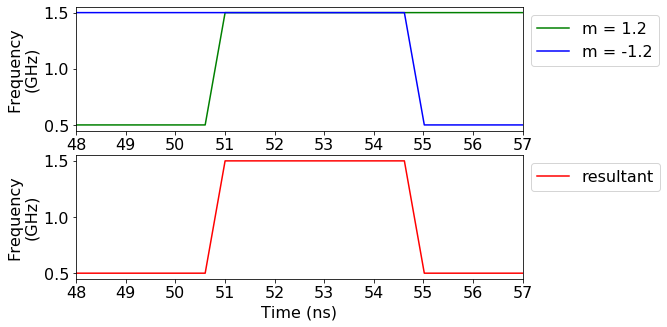

In [413]:
fig, axes = plt.subplots(2, 1, figsize=(8,5))
tlist = np.linspace(0, 100, 250)

axes[0].plot(tlist, [step_t(0.5, 1.5, 50, 1.2, 51, t) for t in tlist], 'g', label="m = 1.2")
axes[0].plot(tlist, [step_t(1.5, 0.5, 56, -1.2, 55, t) for t in tlist], 'b', label="m = -1.2")
axes[0].set_xlim(48, 57)
axes[0].set_ylabel("Frequency\n(GHz)")
axes[0].legend(loc="upper left", bbox_to_anchor=(1,1))

axes[1].plot(tlist, [step_t(0.5, 1.5, 50, 1.2, 51, t)+step_t(1.5, 0.5, 56, -1.2, 55, t)-1.5 for t in tlist], 'r', label="resultant")
axes[1].set_xlim(48, 57)
axes[1].set_xlabel("Time (ns)")
axes[1].set_ylabel("Frequency\n(GHz)")
axes[1].legend(loc="upper left", bbox_to_anchor=(1,1))

In [414]:
# time dependent Hamiltonian
H_t = [H0, [Hq1, w1_t]]

# Evolving the system with thermal losses
res = mesolve(H_t, psi0, times, c_ops, [n1, n2, numOp(a1), numOp(a2), numOp(a3)], options=options)

# without thermal losses
res2 = mesolve(H_t, psi0, times, [], [n1, n2, numOp(a1), numOp(a2), numOp(a3)], options=options)

### 4.2 Plotting the results (With thermal losses)

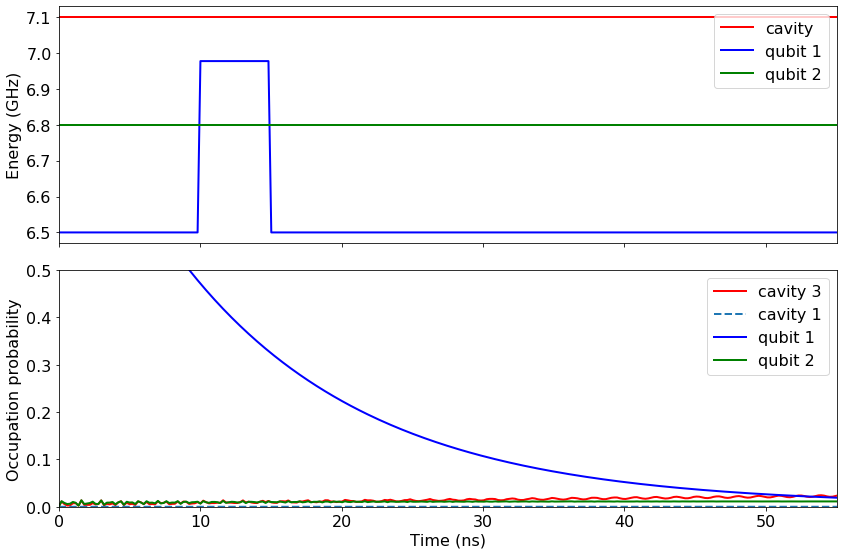

In [425]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(times, np.array(list(map(wf_t, times))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(times, np.array(list(map(w1_t, times))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(times, np.array(list(map(w2_t, times))) / (2*pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend(loc="upper right")
axes[0].set_xlim(0, 55)

axes[1].plot(times, np.real(expect(numOp(a3), res.states)), 'r', linewidth=2, label="cavity 3")
axes[1].plot(times, np.real(expect(numOp(a1), res.states)), '--', linewidth=2, label="cavity 1")
axes[1].plot(times, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(times, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].set_ylim(0., 0.5)
axes[1].legend()

fig.tight_layout()

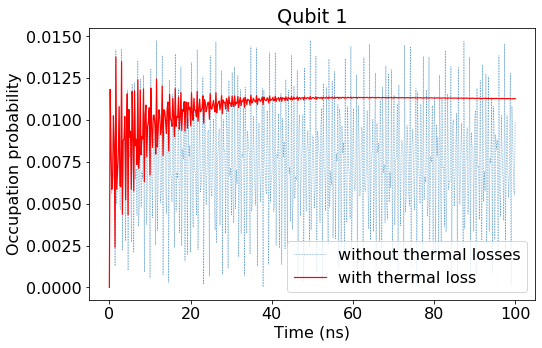

In [416]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(times, res2.expect[1], label="without thermal losses", linestyle=':', lw=0.6)
ax.plot(times, res.expect[1], label="with thermal loss", lw=1.2, color='r')
ax.legend()
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Occupation probability')
ax.set_title('Qubit 1');

## 5. Results

In [417]:
# extract the final state from the result of the simulation
rho_final = res.states[-1]

# trace out the resonator mode and print the two-qubit density matrix
rho_qubits = ptrace(rho_final, [1,2])
rho_qubits

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.93038415+0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.03546799+0.j         0.00232583-0.00165756j
  0.        +0.j        ]
 [0.        +0.j         0.00232583+0.00165756j 0.03299455+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.00115331+0.j        ]]

In [418]:
# compare to the ideal result of the sqrtiswap gate (plus phase correction) for the current initial state
rho_qubits_ideal = ket2dm(tensor(phasegate(0), phasegate(-pi/2)) * sqrtiswap() * tensor(basis(2,1), basis(2,0)))
rho_qubits_ideal

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.  0. ]]

### 5.2 Fidelity and Concurrence

In [419]:
fidelity(rho_qubits, rho_qubits_ideal)

0.19119912421793334

In [420]:
concurrence(rho_qubits)

0